# Step1: Creating Second Quantistion Hamiltonian
Example: $H$ Atom

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from pyscf import ao2mo, fci, gto, mcscf, scf, tools
from qiskit.quantum_info import SparsePauliOp


def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

In [20]:
mol = gto.Mole() # gto = gaussian type orbital
mol.build(
    atom=[
        ["H", (0, 0, 0)]
    ],
    basis="sto-6g",
    spin=1,             # IMPORTANT
    charge=0,
    symmetry=True,
)
print(mol.groupname)
print(mol.irrep_name)


SO3
['s+0']


RHF is a method that finds an approximate ground state energy by assuming electrons are independent and move in an average field (a single Slater determinant).

In [21]:
mf = scf.RHF(mol) # Setting up Restricted Hartree-Fock Calculation
E1 = mf.kernel() # Runs RHF calculation
print(f"Grounf state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
mf.analyze()


converged SCF energy = -0.47103905418349
Grounf state energy by RHF = -0.47103905418349024 Hartree = -12.817632119008627 eV
Wave-function symmetry = SO3
occupancy for each irrep:    s+0
double occ                     0
single occ                     1
**** MO energy ****
MO #1   (s+0 #1 ), energy= -0.47103905418349  occ= 1
 ** Mulliken atomic charges  **
charge of    0H =     -0.00000
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000,  0.00000


((array([1.]), array([-4.4408921e-16])), array([0., 0., 0.]))

## nelecas (Number of active electrons)
 nelecas = number of active electrons = usually total number of valence electrons

 format = (num_spin_up, num_spin_down)
 For a standard calculation (singlet, spin=0), these are just (TotalActive / 2, TotalActive / 2).

for $H_2$ (1,1)

## ncas (Number of Active Orbitals)
 ncas must be large enough to hold all the active electrons

 ### Strategy 1: Full Valence Active Space (FVAS)
 This is the most common and robust starting point.
 
 Rule: Include all molecular orbitals (MOs) that are formed from the valence atomic orbitals (AOs).

 ### Strategy 2: Minimal "Interesting" Space
 For quantum computing (VQE), FVAS is often too large. You want the smallest possible space that captures the physics.
 
 Rule: Pick only the orbitals directly involved in a process.

 LiH example used ncas=5! This means the person who wrote it chose a larger space, likely the $\sigma$, $\sigma^*$, and the 3 p-orbitals from the Li atom, to get a more accurate result. This was a chemical choice.

## cas_space_symmetry (The Practical Tool)
This argument is just a tool to select the ncas orbitals you chose in the previous step. It's more reliable than just picking by energy because orbital energies can be in the "wrong" order.
run mf.analyze() to get the orbitals for cas_space_symmetry


In [22]:
nelecas = (1,0)
ncas = 1
cas_space_symmetry = {'s+0': 1}
mx = mcscf.CASCI(mf, ncas = ncas, nelecas=nelecas)
mo = mcscf.sort_mo_by_irrep(mx, mf.mo_coeff, cas_space_symmetry)

E2 = mx.kernel(mo)[:2] # second value is active_space_energy
h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)

print(f"Grounf state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
print(f"Energy levels = {E2[0]} Hartree = {E2[0]*27.2114} eV")

CASCI E = -0.471039054183490  E(CI) = -0.471039054183490  S^2 = 0.7500000
Grounf state energy by RHF = -0.47103905418349024 Hartree = -12.817632119008627 eV
Energy levels = -0.47103905418349024 Hartree = -12.817632119008627 eV


In [23]:
H = build_hamiltonian(ecore, h1e, h2e)

accuracy of Cholesky decomposition  0.0


# VQE


In [24]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

print(H.num_qubits)


2


3


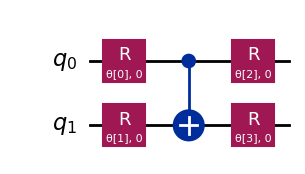

In [25]:
# Pre-defined ansatz circuit
from qiskit.circuit.library import efficient_su2
from scipy.optimize import minimize
# Random initial state and efficient_su2 ansatz
ansatz = efficient_su2(H.num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")


In [26]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy
   

In [27]:
 
# We will start by using a local simulator
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2

backend = AerSimulator()
estimator = BackendEstimatorV2(backend = backend)


In [28]:

res = minimize(
    cost_func,
    x0,
    args=(ansatz, H, estimator),
    method="cobyla",
    options={"maxiter": 100, "disp": True},
)


Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 42   Least value of F = -0.47103905418349007
The corresponding X is:
[4.67489465 3.08630329 6.28167879 6.3104925 ]



In [29]:

print(getattr(res, "fun"), "Hartree")
print(res)
E3 = getattr(res, "fun")
print(f"Ground State Energy by VQE = {E3} Hartree = {E3*27.114} eV")
print(f"Ground state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
print(f"Ground State Energy level CASCI = {E2[0]} Hartree = {E2[0]*27.2114} eV")

-0.47103905418349007 Hartree
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.47103905418349007
       x: [ 4.675e+00  3.086e+00  6.282e+00  6.310e+00]
    nfev: 42
   maxcv: 0.0
Ground State Energy by VQE = -0.47103905418349007 Hartree = -12.77175291513115 eV
Ground state energy by RHF = -0.47103905418349024 Hartree = -12.817632119008627 eV
Ground State Energy level CASCI = -0.47103905418349024 Hartree = -12.817632119008627 eV
